---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [1]:
# 1. Import all the needed packages.

# needed packages
import numpy as np
import pandas as pd
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

In [51]:
df=pd.read_csv('train.csv',encoding='ISO-8859-1',dtype={'zip_code': str, 'non_us_str_code': str, 'grafitti_status': str, 'violator_name':str, 
                        'mailing_address_str_number': str})

In [52]:
df.iloc[:,11:14].head()

,zip_code,non_us_str_code,country
0,60606,NaN,USA
1,48208,NaN,USA
2,48223,NaN,USA
3,48214,NaN,USA
4,48206,NaN,USA


In [53]:
df[['zip_code','non_us_str_code','country']].astype(str,inplace=True)

,zip_code,non_us_str_code,country
0,60606,nan,USA
1,48208,nan,USA
2,48223,nan,USA
3,48214,nan,USA
4,48206,nan,USA
5,908041512,nan,USA
6,48038,nan,USA
7,48211,nan,USA
8,48211,nan,USA
9,48205,nan,USA


In [54]:
df.dtypes

ticket_id                       int64
agency_name                    object
inspector_name                 object
violator_name                  object
violation_street_number       float64
violation_street_name          object
violation_zip_code            float64
mailing_address_str_number     object
mailing_address_str_name       object
city                           object
state                          object
zip_code                       object
non_us_str_code                object
country                        object
ticket_issued_date             object
hearing_date                   object
violation_code                 object
violation_description          object
disposition                    object
fine_amount                   float64
admin_fee                     float64
state_fee                     float64
late_fee                      float64
discount_amount               float64
clean_up_cost                 float64
judgment_amount               float64
payment_amou

In [56]:
df['mailing_address_str_name'] = df['mailing_address_str_name'].str.replace(r"\>"," ")
df['violator_name'] = df['violator_name'].str.replace(r"\>"," ")

In [57]:
df1=df[(df['compliance'] == 0.0) | (df['compliance'] == 1.0)]
df1.shape

(159880, 34)

In [58]:
df1

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
5,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755,E. 17TH,LOG BEACH,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
6,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476,Garfield,Clinton,...,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
7,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228,Mt. Elliott,Detroit,...,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
8,18733,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228,Mt. Elliott,Detroit,...,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
9,28204,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Inc, Nanno",15307.0,SEVEN MILE,NaN,1537,E. Seven Mile,Detroit,...,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
12,18743,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Gardner Resale, GAR",9100.0,VAN DYKE,NaN,91,Van Dyke,Detroit,...,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,IN COLLECTION,NaN,non-compliant by no payment,0.0
13,18741,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Hardaway, Kevin",20024.0,SCHAEFER,NaN,224,Schaefer,Detroit,...,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,IN COLLECTION,NaN,non-compliant by no payment,0.0
14,18978,"Buildings, Safety Engineering & Env Department","Williams, Darrin","TLC Hand Car Wash, a/k/a",9425.0,VAN DYKE,NaN,9425,Van Dyke,Detroit,...,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


In [59]:
df1.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance'],
      dtype='object')

In [60]:
X=df1.loc[:,'ticket_id':'judgment_amount']

In [61]:
X['grafitti_status']=df1['grafitti_status']

In [62]:
X.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3,S. WICKER,CHICAGO,...,Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,NaN
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959,Martin Luther King,Detroit,...,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,NaN


In [63]:
y=df1.iloc[:,-1].astype(int)

In [64]:
y.head()

0    0
1    1
5    0
6    0
7    0
Name: compliance, dtype: int64

In [65]:
X.shape

(159880, 27)

In [66]:
y.shape

(159880,)

In [67]:
y.dtype

dtype('int64')

In [68]:
np.bincount(y)

array([148283,  11597])

In [69]:
y.value_counts()

0    148283
1     11597
Name: compliance, dtype: int64

In [70]:
((y.value_counts()[1])/(y.value_counts()[0]))*100

7.8208560657661366

In [71]:
X = X.fillna('')

In [72]:
X['mailing_address_str_name'] = X['mailing_address_str_name'].str.replace(r"\>","")
X['mailing_address_str_number'] = X['mailing_address_str_number'].str.replace(r"\>"," ")
X['violator_name'] = X['violator_name'].str.replace(r"\>"," ")

In [86]:
X_cat=X.select_dtypes(include=[object])

In [101]:
from sklearn import preprocessing

In [87]:
encod=preprocessing.LabelEncoder()

In [88]:
X_encat=X_cat.apply(encod.fit_transform)

In [89]:
X_encat.head(20)

,agency_name,inspector_name,violator_name,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,grafitti_status
0,0,125,37134,1571,0,8038,20433,543,17,2260,0,4,1,127,143,69,2,0
1,0,153,54904,290,0,7936,13954,952,25,1593,0,4,2,260,74,47,3,0
5,0,125,41505,1186,0,7457,6186,1930,7,2987,0,4,3,127,143,69,2,0
6,0,153,21700,202,0,10316,9154,725,25,1406,0,4,4,53,73,48,2,0
7,0,153,66157,1151,0,12852,14107,952,25,1598,0,4,6,53,72,152,2,0
8,0,153,66157,1151,0,12852,14107,952,25,1598,0,4,5,53,72,152,2,0
9,0,153,38229,1425,0,2621,6708,952,25,1587,0,4,7,323,74,47,2,0
12,0,153,29946,1579,0,13449,23909,952,25,1603,0,4,8,53,74,47,2,0
13,0,153,35231,1406,0,5940,22489,952,25,1664,0,4,9,53,74,47,2,0
14,0,153,74524,1579,0,13706,23909,952,25,1603,0,4,10,69,74,47,2,0


In [93]:
X2=X_encat.copy()

In [94]:
X2.dtypes

agency_name                   int64
inspector_name                int64
violator_name                 int64
violation_street_name         int64
violation_zip_code            int64
mailing_address_str_number    int64
mailing_address_str_name      int64
city                          int64
state                         int64
zip_code                      int64
non_us_str_code               int64
country                       int64
ticket_issued_date            int64
hearing_date                  int64
violation_code                int64
violation_description         int64
disposition                   int64
grafitti_status               int64
dtype: object

In [91]:
X_num=X.select_dtypes(include=['int64','float64'])

In [96]:
X2[X_num.columns]=X_num[X_num.columns]

In [99]:
X2.head(5)

,agency_name,inspector_name,violator_name,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,...,grafitti_status,ticket_id,violation_street_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount
0,0,125,37134,1571,0,8038,20433,543,17,2260,...,0,22056,2900.0,250.0,20.0,10.0,25.0,0.0,0.0,305.0
1,0,153,54904,290,0,7936,13954,952,25,1593,...,0,27586,4311.0,750.0,20.0,10.0,75.0,0.0,0.0,855.0
5,0,125,41505,1186,0,7457,6186,1930,7,2987,...,0,22046,6478.0,250.0,20.0,10.0,25.0,0.0,0.0,305.0
6,0,153,21700,202,0,10316,9154,725,25,1406,...,0,18738,8027.0,750.0,20.0,10.0,75.0,0.0,0.0,855.0
7,0,153,66157,1151,0,12852,14107,952,25,1598,...,0,18735,8228.0,100.0,20.0,10.0,10.0,0.0,0.0,140.0


In [102]:
from sklearn.model_selection import train_test_split

In [100]:
X_train,X_test,y_train,y_test=train_test_split(X2,y,random_state=0)

In [103]:
from sklearn.ensemble import GradientBoostingClassifier

In [105]:
clf=GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse',
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, 
                           min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, 
                           max_leaf_nodes=None, warm_start=False, presort='auto').fit(X_train,y_train)

In [107]:
y_pred_prob = clf.predict_proba(X_test)

In [112]:
y_pred_prob

array([[ 0.98570777,  0.01429223],
       [ 0.97871333,  0.02128667],
       [ 0.73864575,  0.26135425],
       ..., 
       [ 0.98040283,  0.01959717],
       [ 0.97511606,  0.02488394],
       [ 0.98355864,  0.01644136]])

In [117]:
from sklearn.metrics import roc_curve, auc

In [113]:
fpr, tpr,_= roc_curve(y_test, y_pred_prob[:,1])

In [114]:
fpr,tpr,_

(array([ 0.        ,  0.        ,  0.        , ...,  0.99986515,
         0.99991909,  1.        ]),
 array([  3.45781466e-04,   1.72890733e-03,   2.42047026e-03, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]),
 array([ 0.97603018,  0.96782542,  0.96729804, ...,  0.00877067,
         0.00852882,  0.00769023]))

In [115]:
roc_auc = auc(fpr, tpr)

In [116]:
roc_auc

0.8243411127541902

<IPython.core.display.Javascript object>


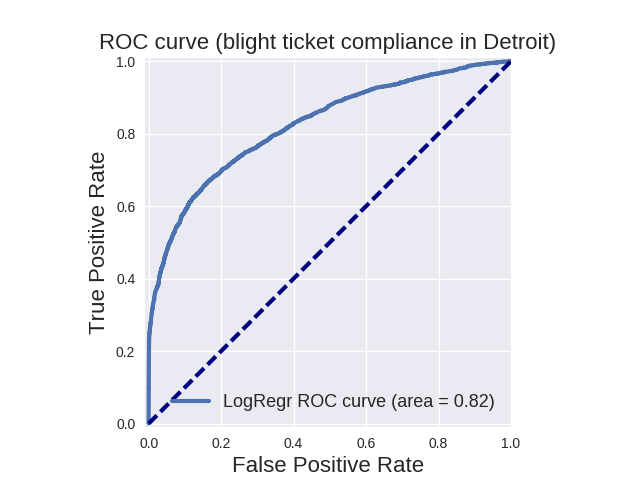

In [120]:
'''import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
plt.figure()
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (blight ticket compliance in Detroit)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
# The dotted line here is the classifier curve that secretly results from a classifier
# that randomly guesses the label for a binary class. 
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()'''

In [129]:
df2=pd.read_csv('test.csv',encoding='ISO-8859-1',dtype={'zip_code': str, 'non_us_str_code': str, 'grafitti_status': str, 'violator_name':str, 
                        'mailing_address_str_number': str})

In [131]:
df2['mailing_address_str_name'] = df2['mailing_address_str_name'].str.replace(r"\>"," ")
df2['violator_name'] = df2['violator_name'].str.replace(r"\>"," ")


In [132]:
df2.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [137]:
df2.dtypes

ticket_id                       int64
agency_name                    object
inspector_name                 object
violator_name                  object
violation_street_number       float64
violation_street_name          object
violation_zip_code             object
mailing_address_str_number     object
mailing_address_str_name       object
city                           object
state                          object
zip_code                       object
non_us_str_code                object
country                        object
ticket_issued_date             object
hearing_date                   object
violation_code                 object
violation_description          object
disposition                    object
fine_amount                   float64
admin_fee                     float64
state_fee                     float64
late_fee                      float64
discount_amount               float64
clean_up_cost                 float64
judgment_amount               float64
grafitti_sta

In [134]:
df2 = df2.fillna('')

In [138]:
df2_cat=df2.select_dtypes(include=[object])

In [139]:
df2_encat=df2_cat.apply(encod.fit_transform)

In [140]:
test_X=df2_encat.copy()

In [142]:
df2_num=df2.select_dtypes(include=['int64','float64'])
test_X[df2_num.columns]=df2_num[df2_num.columns]

In [144]:
ans_pred = clf.predict_proba(test_X)
    
ans = pd.Series(data = ans_pred[:,1], index = test_X['ticket_id'], dtype='float32')

In [146]:
def blight_model():
    return ans
blight_model()

ticket_id
284932    0.540177
285362    0.416560
285361    0.549752
285338    0.587751
285346    0.615268
285345    0.568921
285347    0.578602
285342    0.548722
285530    0.520008
284989    0.486356
285344    0.529923
285343    0.564625
285340    0.540213
285341    0.528147
285349    0.571862
285348    0.529344
284991    0.490191
285532    0.489664
285406    0.463789
285001    0.506116
285006    0.437458
285405    0.387709
285337    0.481882
285496    0.569761
285497    0.598197
285378    0.504084
285589    0.460954
285585    0.501097
285501    0.590844
285581    0.391965
            ...   
376367    0.700989
376366    0.749756
376362    0.758592
376363    0.775713
376365    0.700989
376364    0.749756
376228    0.791532
376265    0.742171
376286    0.987794
376320    0.775398
376314    0.749756
376327    0.989599
376385    0.989826
376435    0.990413
376370    0.990720
376434    0.871426
376459    0.828242
376478    0.643040
376473    0.755456
376484    0.726939
376482    0.648080
37